# Import

In [1]:
import numpy as np
from pdg_const import pdg
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl
import sys
import time
from helperfunctions import display_time, prepare_plot
import cmath as c
import scipy.integrate as integrate
from scipy.optimize import fminbound
from array import array as arr
import collections
from itertools import compress
import tensorflow as tf
import zfit
from zfit import ztf
from IPython.display import clear_output
import os

c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\util\execution.py:53: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# chunksize = 1000000
# zfit.run.chunking.active = True
# zfit.run.chunking.max_n_points = chunksize

# Build model and graphs
## Create graphs

In [3]:
def formfactor( q2, subscript): #returns real value
    #check if subscript is viable

    if subscript != "0" and subscript != "+" and subscript != "T":
        raise ValueError('Wrong subscript entered, choose either 0, + or T')

    #get constants

    mK = ztf.constant(pdg['Ks_M'])
    mbstar0 = ztf.constant(pdg["mbstar0"])
    mbstar = ztf.constant(pdg["mbstar"])
    b0 = ztf.constant(pdg["b0"])
    bplus = ztf.constant(pdg["bplus"])
    bT = ztf.constant(pdg["bT"])

    mmu = ztf.constant(pdg['muon_M'])
    mb = ztf.constant(pdg['bquark_M'])
    ms = ztf.constant(pdg['squark_M'])
    mB = ztf.constant(pdg['Bplus_M'])

    #N comes from derivation in paper

    N = 3

    #some helperfunctions

    tpos = (mB - mK)**2
    tzero = (mB + mK)*(ztf.sqrt(mB)-ztf.sqrt(mK))**2

    z_oben = ztf.sqrt(tpos - q2) - ztf.sqrt(tpos - tzero)
    z_unten = ztf.sqrt(tpos - q2) + ztf.sqrt(tpos - tzero)
    z = tf.divide(z_oben, z_unten)

    #calculate f0

    if subscript == "0":
        prefactor = 1/(1 - q2/(mbstar0**2))
        _sum = 0

        for i in range(N):
            _sum += b0[i]*(tf.pow(z,i))

        return tf.complex(prefactor * _sum, ztf.constant(0.0))

    #calculate f+ or fT

    else:
        prefactor = 1/(1 - q2/(mbstar**2))
        _sum = 0

        if subscript == "T":
            b = bT
        else:
            b = bplus

        for i in range(N):
            _sum += b[i] * (tf.pow(z, i) - ((-1)**(i-N)) * (i/N) * tf.pow(z, N))

        return tf.complex(prefactor * _sum, ztf.constant(0.0))

def resonance(q, _mass, width, phase, scale):

    q2 = tf.pow(q, 2)

    mmu = ztf.constant(pdg['muon_M'])

    p = 0.5 * ztf.sqrt(q2 - 4*(mmu**2))

    p0 =  0.5 * ztf.sqrt(_mass**2 - 4*mmu**2)

    gamma_j = tf.divide(p, q2) * _mass * width / p0

    #Calculate the resonance

    _top = tf.complex(_mass * width, ztf.constant(0.0))

    _bottom = tf.complex(_mass**2 - q2, -_mass*gamma_j)

    com = _top/_bottom

    #Rotate by the phase

    r = ztf.to_complex(scale*tf.abs(com))

    _phase = tf.angle(com)

    _phase += phase

    com = r * tf.exp(tf.complex(ztf.constant(0.0), _phase))

    return com

def bifur_gauss(q, mean, sigma_L, sigma_R, scale):

    _exp = tf.where(q < mean, ztf.exp(- tf.pow((q-mean),2) / (2 * sigma_L**2)), ztf.exp(- tf.pow((q-mean),2) / (2 * sigma_R**2)))

    #Scale so the total area under curve is 1 and the top of the cusp is continuous

    dgamma = scale*_exp/(ztf.sqrt(2*np.pi))*2*(sigma_L*sigma_R)/(sigma_L+sigma_R)

    com = ztf.complex(dgamma, ztf.constant(0.0))

    return com

def axiv_nonres(q):

    GF = ztf.constant(pdg['GF'])
    alpha_ew = ztf.constant(pdg['alpha_ew'])
    Vtb = ztf.constant(pdg['Vtb'])
    Vts = ztf.constant(pdg['Vts'])
    C10eff = ztf.constant(pdg['C10eff'])

    mmu = ztf.constant(pdg['muon_M'])
    mb = ztf.constant(pdg['bquark_M'])
    ms = ztf.constant(pdg['squark_M'])
    mK = ztf.constant(pdg['Ks_M'])
    mB = ztf.constant(pdg['Bplus_M'])

    q2 = tf.pow(q, 2)

    #Some helperfunctions

    beta = ztf.sqrt(tf.abs(1. - 4. * mmu**2. / q2))

    kabs = ztf.sqrt(mB**2. +tf.pow(q2, 2)/mB**2. + mK**4./mB**2. - 2. * (mB**2. * mK**2. + mK**2. * q2 + mB**2. * q2) / mB**2.)

    #prefactor in front of whole bracket

    prefactor1 = GF**2. *alpha_ew**2. * (tf.abs(Vtb*Vts))**2. * kabs * beta / (128. * np.pi**5.)

    #left term in bracket

    bracket_left = 2./3. * kabs**2. * beta**2. *tf.abs(tf.complex(C10eff, ztf.constant(0.0))*formfactor(q2, "+"))**2.

    #middle term in bracket

    _top = 4. * mmu**2. * (mB**2. - mK**2.) * (mB**2. - mK**2.)

    _under = q2 * mB**2.

    bracket_middle = _top/_under *tf.pow(tf.abs(tf.complex(C10eff, ztf.constant(0.0)) * formfactor(q2, "0")), 2)

    #Note sqrt(q2) comes from derivation as we use q2 and plot q

    return prefactor1 * (bracket_left + bracket_middle) * 2 *ztf.sqrt(q2)

def vec(q, funcs):
    
    q2 = tf.pow(q, 2)

    GF = ztf.constant(pdg['GF'])
    alpha_ew = ztf.constant(pdg['alpha_ew'])
    Vtb = ztf.constant(pdg['Vtb'])
    Vts = ztf.constant(pdg['Vts'])
    C7eff = ztf.constant(pdg['C7eff'])

    mmu = ztf.constant(pdg['muon_M'])
    mb = ztf.constant(pdg['bquark_M'])
    ms = ztf.constant(pdg['squark_M'])
    mK = ztf.constant(pdg['Ks_M'])
    mB = ztf.constant(pdg['Bplus_M'])

    #Some helperfunctions

    beta = ztf.sqrt(tf.abs(1. - 4. * mmu**2. / q2))

    kabs = ztf.sqrt(mB**2. + tf.pow(q2, 2)/mB**2. + mK**4./mB**2. - 2 * (mB**2 * mK**2 + mK**2 * q2 + mB**2 * q2) / mB**2)

    #prefactor in front of whole bracket

    prefactor1 = GF**2. *alpha_ew**2. * (tf.abs(Vtb*Vts))**2 * kabs * beta / (128. * np.pi**5.)

    #right term in bracket

    prefactor2 = kabs**2 * (1. - 1./3. * beta**2)

    abs_bracket = tf.abs(c9eff(q, funcs) * formfactor(q2, "+") + tf.complex(2.0 * C7eff * (mb + ms)/(mB + mK), ztf.constant(0.0)) * formfactor(q2, "T"))**2

    bracket_right = prefactor2 * abs_bracket

    #Note sqrt(q2) comes from derivation as we use q2 and plot q

    return prefactor1 * bracket_right * 2 * ztf.sqrt(q2)

def c9eff(q, funcs):

    C9eff_nr = tf.complex(ztf.constant(pdg['C9eff']), ztf.constant(0.0))

    c9 = C9eff_nr

    c9 = c9 + funcs

    return c9

In [4]:
def G(y):
    
    def inner_rect_bracket(q):
        return tf.log(ztf.to_complex((1+tf.sqrt(q))/(1-tf.sqrt(q)))-tf.complex(ztf.constant(0), -1*ztf.constant(np.pi)))    
    
    def inner_right(q):
        return ztf.to_complex(2 * tf.atan(1/tf.sqrt(-q)))
    
    big_bracket = tf.where(y > ztf.const(0.0), inner_rect_bracket(y), inner_right(y))
    
    return ztf.to_complex(tf.sqrt(tf.abs(y))) * big_bracket

def h_S(m, q):
    
    return ztf.to_complex(2) - G(ztf.to_complex(1) - 4*tf.pow(m, 2) / ztf.to_complex(tf.pow(q, 2)))

def h_P(m,q):
    
    return ztf.to_complex(2/3) + (ztf.to_complex(1) - 4*tf.pow(m, 2) / ztf.to_complex(tf.pow(q, 2))) * h_S(m,q)

def two_p_ccbar(mD, m_D_bar, m_D_star, q):
    
    
    #Load constants
    nu_D_bar = ztf.to_complex(pdg["nu_D_bar"])
    nu_D = ztf.to_complex(pdg["nu_D"])
    nu_D_star = ztf.to_complex(pdg["nu_D_star"])
    
    phase_D_bar = ztf.to_complex(pdg["phase_D_bar"])
    phase_D = ztf.to_complex(pdg["phase_D"])
    phase_D_star = ztf.to_complex(pdg["phase_D_star"])
    
    #Calculation
    left_part =  nu_D_bar * tf.exp(tf.complex(ztf.constant(0.0), phase_D_bar)) * h_S(m_D_bar, q) 
    
    right_part_D = nu_D * tf.exp(tf.complex(ztf.constant(0.0), phase_D)) * h_P(m_D, q) 
    
    right_part_D_star = nu_D_star * tf.exp(tf.complex(ztf.constant(0.0), phase_D_star)) * h_P(m_D_star, q) 

    return left_part + right_part_D + right_part_D_star

## Build pdf

In [5]:
class total_pdf(zfit.pdf.ZPDF):
    _N_OBS = 1  # dimension, can be omitted
    _PARAMS = ['jpsi_mass', 'jpsi_scale', 'jpsi_phase', 'jpsi_width',
                'psi2s_mass', 'psi2s_scale', 'psi2s_phase', 'psi2s_width'#,
                #'cusp_mass', 'sigma_L', 'sigma_R', 'cusp_scale'
                ]  # the name of the parameters

    def _unnormalized_pdf(self, x):
        
        x = x.unstack_x()

        def jpsi_res(q):
            return resonance(q, _mass = self.params['jpsi_mass'], scale = self.params['jpsi_scale'], phase = self.params['jpsi_phase'], width = self.params['jpsi_width'])

        def psi2s_res(q):
            return resonance(q, _mass = self.params['psi2s_mass'], scale = self.params['psi2s_scale'], phase = self.params['psi2s_phase'], width = self.params['psi2s_width'])

        def cusp(q):
            return bifur_gauss(q, mean = self.params['cusp_mass'], sigma_L = self.params['sigma_L'], sigma_R = self.params['sigma_R'], scale = self.params['cusp_scale'])

        funcs = jpsi_res(x) + psi2s_res(x) #+ cusp(x)

        vec_f = vec(x, funcs)

        axiv_nr = axiv_nonres(x)

        tot = vec_f + axiv_nr

        return tot

## Load data

In [6]:
x_min = 2*pdg['muon_M']
x_max = (pdg["Bplus_M"]-pdg["Ks_M"]-0.1)

obs = zfit.Space('q', limits = (x_min, x_max))

# with open(r"./data/slim_points/slim_points_toy_0_range({0}-{1}).pkl".format(int(x_min), int(x_max)), "rb") as input_file:
#     part_set = pkl.load(input_file)

# x_part = part_set['x_part']

# x_part = x_part.astype('float64')

# data = zfit.data.Data.from_numpy(array=x_part, obs=obs)

## Setup parameters

In [7]:
#jpsi

jpsi_mass, jpsi_width, jpsi_phase, jpsi_scale = pdg["jpsi"]
# jpsi_scale *= pdg["factor_jpsi"]

jpsi_m = zfit.Parameter("jpsi_m", ztf.constant(jpsi_mass), floating = False)
jpsi_w = zfit.Parameter("jpsi_w", ztf.constant(jpsi_width), floating = False)
jpsi_p = zfit.Parameter("jpsi_p", ztf.constant(jpsi_phase))
jpsi_s = zfit.Parameter("jpsi_s", ztf.constant(jpsi_scale))

#psi2s

psi2s_mass, psi2s_width, psi2s_phase, psi2s_scale = pdg["psi2s"]

psi2s_m = zfit.Parameter("psi2s_m", ztf.constant(psi2s_mass), floating = False)
psi2s_w = zfit.Parameter("psi2s_w", ztf.constant(psi2s_width), floating = False)
psi2s_p = zfit.Parameter("psi2s_p", ztf.constant(psi2s_phase))
psi2s_s = zfit.Parameter("psi2s_s", ztf.constant(psi2s_scale))

#cusp

# cusp_mass, sigma_R, sigma_L, cusp_scale = 3550, 3e-7, 200, 0

# cusp_m = zfit.Parameter("cusp_m", ztf.constant(cusp_mass), floating = False)
# sig_L = zfit.Parameter("sig_L", ztf.constant(sigma_L), floating = False)
# sig_R = zfit.Parameter("sig_R", ztf.constant(sigma_R), floating = False)
# cusp_s = zfit.Parameter("cusp_s", ztf.constant(cusp_scale), floating = False)

Instructions for updating:
Colocations handled automatically by placer.


## Setup pdf

In [8]:
total_f = total_pdf(obs=obs, jpsi_mass = jpsi_m, jpsi_scale = jpsi_s, jpsi_phase = jpsi_p, jpsi_width = jpsi_w,
            psi2s_mass = psi2s_m, psi2s_scale = psi2s_s, psi2s_phase = psi2s_p, psi2s_width = psi2s_w)#,
            #cusp_mass = cusp_m, sigma_L = sig_L, sigma_R = sig_R, cusp_scale = cusp_s)

# print(total_pdf.obs)

## Test if graphs actually work and compute values

In [9]:
def total_test_tf(xq):

    def jpsi_res(q):
        return resonance(q, jpsi_m, jpsi_s, jpsi_p, jpsi_w)

    def psi2s_res(q):
        return resonance(q, psi2s_m, psi2s_s, psi2s_p, psi2s_w)

    def cusp(q):
        return bifur_gauss(q, cusp_m, sig_L, sig_R, cusp_s)

    funcs = jpsi_res(xq) + psi2s_res(xq) + cusp(xq)

    vec_f = vec(xq, funcs)

    axiv_nr = axiv_nonres(xq)

    tot = vec_f + axiv_nr
    
    return tot

def jpsi_res(q):
    return resonance(q, jpsi_m, jpsi_s, jpsi_p, jpsi_w)

# calcs = zfit.run(total_test_tf(x_part))

test_q = np.linspace(x_min, x_max, 2000000)

probs = total_f.pdf(test_q)

calcs_test = zfit.run(probs)
res_y = zfit.run(jpsi_res(test_q))

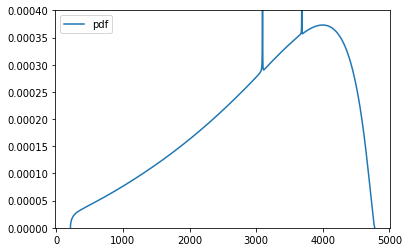

In [10]:
plt.clf()
# plt.plot(x_part, calcs, '.')
plt.plot(test_q, calcs_test, label = 'pdf')
# plt.plot(test_q, res_y, label = 'res')
plt.legend()
plt.ylim(0.0, 4e-4)
# plt.yscale('log')
# plt.xlim(3080, 3110)
plt.savefig('test.png')
# print(jpsi_width)

## Adjust scaling of different parts

In [11]:
# total_f.update_integration_options(draws_per_dim=2000000, mc_sampler=None)
# inte = total_f.integrate(limits = (3090, 3102), norm_range=False)
# inte_fl = zfit.run(inte)
# print(inte_fl)
# print(pdg["jpsi_BR"]/pdg["NR_BR"], inte_fl/pdg["NR_auc"])

In [12]:
# print(x_min)
# print(x_max)
# # total_f.update_integration_options(draws_per_dim=2000000, mc_sampler=None)
# total_f.update_integration_options(mc_sampler=lambda dim, num_results,
#                                     dtype: tf.random_uniform(maxval=1., shape=(num_results, dim), dtype=dtype),
#                                    draws_per_dim=1000000)
# # _ = []

# # for i in range(10):

# #     inte = total_f.integrate(limits = (x_min, x_max))
# #     inte_fl = zfit.run(inte)
# #     print(inte_fl)
# #     _.append(inte_fl)

# # print("mean:", np.mean(_))

# _ = time.time()

# inte = total_f.integrate(limits = (x_min, x_max))
# inte_fl = zfit.run(inte)
# print(inte_fl)
# print("Time taken: {}".format(display_time(int(time.time() - _))))

## Tensorflow scaling

In [13]:
# def scaling_func(x):

#     funcs = resonance(x, _mass = ztf.constant(jpsi_mass), scale = ztf.constant(jpsi_scale), phase = ztf.constant(jpsi_phase), width = ztf.constant(jpsi_width)) + resonance(x, _mass = ztf.constant(psi2s_mass), scale = ztf.constant(psi2s_scale), phase = ztf.constant(psi2s_phase), width = ztf.constant(psi2s_width))

#     vec_f = vec(x, funcs)

#     axiv_nr = axiv_nonres(x)

#     tot = vec_f + axiv_nr

#     return tot


# def s_func(x):
    
#     q = ztf.constant(x)
    
#     return zfit.run(scaling_func(q))
    

# print(integrate.quad(s_func, x_min, x_max, limit = 50))

In [14]:
# factor_jpsi = pdg["NR_auc"]*pdg["jpsi_BR"]/(pdg["NR_BR"]*pdg["jpsi_auc"])
# factor_jpsi = pdg["NR_auc"]*pdg["jpsi_BR"]/(pdg["NR_BR"]*inte_fl)
# print(np.sqrt(factor_jpsi)*jpsi_scale)
# print(np.sqrt(factor_jpsi))
# # print(psi2s_scale)
# factor_psi2s = pdg["NR_auc"]*pdg["psi2s_BR"]/(pdg["NR_BR"]*pdg["psi2s_auc"])
# factor_psi2s = pdg["NR_auc"]*pdg["psi2s_BR"]/(pdg["NR_BR"]*inte_fl)
# print(np.sqrt(factor_psi2s)*psi2s_scale)
# print(np.sqrt(factor_psi2s))

In [15]:
# def _t_f(xq):

#     def jpsi_res(q):
#         return resonance(q, jpsi_m, jpsi_s, jpsi_p, jpsi_w)

#     def psi2s_res(q):
#         return resonance(q, psi2s_m, psi2s_s, psi2s_p, psi2s_w)

#     funcs = psi2s_res(xq) + jpsi_res(xq)

#     vec_f = vec(xq, funcs)

#     axiv_nr = axiv_nonres(xq)

#     tot = vec_f + axiv_nr
    
#     return tot

# def t_f(x):
#     _ = np.array(x)
#     probs = zfit.run(_t_f(_))
#     return probs

In [16]:
# print(36000*(1+ pdg["jpsi_BR"]/pdg["NR_BR"] + pdg["psi2s_BR"]/pdg["NR_BR"]))

In [17]:
# start = time.time()

# result, err = integrate.quad(lambda x: t_f(x), x_min, x_max, limit = 5)
# print(result, "{0:.2f} %".format(err/result))
# print("Time:", time.time()-start)

# Sampling
## One sample
! total_f.sample() always returns the same set !

In [18]:
# nevents = int(pdg["number_of_decays"])
# event_stack = 5000

# calls = int(nevents/event_stack + 1)

# total_samp = []

# start = time.time()

# samp = total_f.sample(n=event_stack)
# s = samp.unstack_x()

# for call in range(calls):

#     sam = zfit.run(s)
#     clear_output(wait=True)
    
# #     if call != 0:
# #         print(np.sum(_last_sam-sam))
    
# #     _last_sam = sam
    
#     c = call + 1    
#     print("{0}/{1}".format(c, calls))
#     print("Time taken: {}".format(display_time(int(time.time() - start))))
#     print("Projected time left: {}".format(display_time(int((time.time() - start)/c*(calls-c)))))
    
#     with open("data/zfit_toys/toy_1/{}.pkl".format(call), "wb") as f:
#         pkl.dump(sam, f, pkl.HIGHEST_PROTOCOL)

In [19]:
# print("Time to generate full toy: {} s".format(int(time.time()-start)))

# total_samp = []

# for call in range(calls):
#     with open(r"data/zfit_toys/toy_1/{}.pkl".format(call), "rb") as input_file:
#         sam = pkl.load(input_file)
#         total_samp = np.append(total_samp, sam)

# total_samp = total_samp.astype('float64')

# data2 = zfit.data.Data.from_numpy(array=total_samp[:int(nevents)], obs=obs)

# print(total_samp[:nevents].shape)

In [20]:
# bins = int((x_max-x_min)/7)

# # calcs = zfit.run(total_test_tf(samp))

# plt.hist(total_samp[:event_stack], bins = bins, range = (x_min,x_max))

# # plt.plot(sam, calcs, '.')
# # plt.plot(test_q, calcs_test)
# plt.ylim(0, 20)
# # plt.xlim(3000, 3750)

# plt.savefig('test2.png')

## Toys

In [21]:
nr_of_toys = 1
nevents = int(pdg["number_of_decays"])
event_stack = 100000

calls = int(nevents/event_stack + 1)

total_samp = []

start = time.time()

# sampler = total_f.create_sampler(n=event_stack)

# for toy in range(nr_of_toys):
    
#     dirName = 'data/zfit_toys/toy_{0}'.format(toy)
    
#     if not os.path.exists(dirName):
#         os.mkdir(dirName)
#         print("Directory " , dirName ,  " Created ")

#     for call in range(calls):

#         sampler.resample(n=event_stack)
#         s = sampler.unstack_x()
#         sam = zfit.run(s)
# #         clear_output(wait=True)

#         c = call + 1    
#         print("{0}/{1}".format(c, calls))
#         print("Time taken: {}".format(display_time(int(time.time() - start))))
#         print("Projected time left: {}".format(display_time(int((time.time() - start)/c*(calls-c)))))

#         with open("data/zfit_toys/toy_{0}/{1}.pkl".format(toy, call), "wb") as f:
#             pkl.dump(sam, f, pkl.HIGHEST_PROTOCOL)

In [22]:
# with open(r"data/zfit_toys/toy_0/0.pkl", "rb") as input_file:
#     sam = pkl.load(input_file)
# print(sam[:10])

# with open(r"data/zfit_toys/toy_0/1.pkl", "rb") as input_file:
#     sam2 = pkl.load(input_file)
# print(sam2[:10])

# print(np.sum(sam-sam2))

In [23]:
print("Time to generate full toy: {} s".format(int(time.time()-start)))

total_samp = []

for call in range(calls):
    with open(r"data/zfit_toys/toy_0/{}.pkl".format(call), "rb") as input_file:
        sam = pkl.load(input_file)
        total_samp = np.append(total_samp, sam)

total_samp = total_samp.astype('float64')

data2 = zfit.data.Data.from_numpy(array=total_samp[:int(nevents)], obs=obs)

data3 = zfit.data.Data.from_numpy(array=total_samp, obs=obs)

print(total_samp[:nevents].shape)

Time to generate full toy: 0 s
(5404696,)


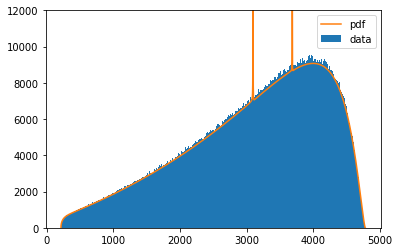

In [24]:
bins = int((x_max-x_min)/7)

# calcs = zfit.run(total_test_tf(samp))

plt.hist(total_samp[:nevents], bins = bins, range = (x_min,x_max), label = 'data')
plt.plot(test_q, calcs_test*nevents*4.5 , label = 'pdf')

# plt.plot(sam, calcs, '.')
# plt.plot(test_q, calcs_test)
# plt.yscale('log')
plt.ylim(0, 12000)
# plt.xlim(3080, 3110)

plt.legend()

plt.savefig('test2.png')

In [25]:
# sampler = total_f.create_sampler(n=nevents)
# nll = zfit.loss.UnbinnedNLL(model=total_f, data=sampler, fit_range = (x_min, x_max))

# # for param in pdf.get_dependents():
# #     param.set_value(initial_value)

# sampler.resample(n=nevents)

# # Randomise initial values
# # for param in pdf.get_dependents():
# #     param.set_value(random value here)

# # Minimise the NLL
# minimizer = zfit.minimize.MinuitMinimizer(verbosity = 10)
# minimum = minimizer.minimize(nll)

# Fitting

In [26]:
nll = zfit.loss.UnbinnedNLL(model=total_f, data=data3, fit_range = (x_min, x_max))

minimizer = zfit.minimize.MinuitMinimizer()
minimizer._use_tfgrad = False
result = minimizer.minimize(nll)

param_errors = result.error()

for var, errors in param_errors.items():
    print('{}: ^{{+{}}}_{{{}}}'.format(var.name, errors['upper'], errors['lower']))

print("Function minimum:", result.fmin)

FCN = 18537900.293873098 
 TOTAL NCALL = 194 
 NCALLS = 194 
 
 
 EDM = 0.03059806673262826 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 jpsi_s 
 464.524 
 0.229484 
 
 
 
 
 No 
 
 
 1 
 psi2s_s 
 76.5024 
 0.0505517 
 
 
 
 
 No 
 
 
 2 
 psi2s_p 
 0.30538 
 0.0245293 
 
 
 
 
 No 
 
 
 3 
 jpsi_p 
 -9.42323 
 0.0114089 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & $jpsi_{s}$ & 464.524 & 0.229484 & & & & & No\\
\hline
1 & $psi2s_{s}$ & 76.5024 & 0.0505517 & & & & & No\\
\hline
2 & $psi2s_{p}$ & 0.30538 & 0.0245293 & & & & & No\\
\hline
3 & $jpsi_{p}$ & -9.42323 & 0.0114089 & & & & & No\\
\hline
\end{tabular}

RuntimeError: Function mimimum is not valid. Make sure migrad converge first

In [ ]:
(-7.95933+2*np.pi)/np.pi+np.pi

In [ ]:
display_time(int(395*pdg["number_of_decays"]/100000))

In [ ]:
print(display_time(22376))

In [ ]:
# probs = total_f.pdf(test_q)

calcs_test = zfit.run(probs)
res_y = zfit.run(jpsi_res(test_q))

In [ ]:
plt.clf()
# plt.plot(x_part, calcs, '.')
plt.plot(test_q, calcs_test, label = 'pdf')
# plt.plot(test_q, res_y, label = 'res')
plt.legend()
plt.ylim(0.0, 5e-4)
# plt.yscale('log')
# plt.xlim(3080, 3110)
plt.savefig('test3.png')
print(jpsi_width)